In [122]:
import numpy as np
import pandas as pd
import sys, os, glob, corner
import matplotlib.pyplot as plt
from jaxstar.utils import *

In [123]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='sans-serif')
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

In [124]:
# get rotation info
drot = pd.read_csv("mazeh+15.tsv", delimiter="|", comment="#")
drot["kepid"] = drot.KIC
prots, vars, lphs = [], [], []
for i in range(len(drot)):
    try:
        prots.append(float(drot.Prot[i]))
    except:
        prots.append(np.nan)
    try:
        vars.append(float(drot.Rvar[i]))
    except:
        vars.append(np.nan)
    try:
        lphs.append(float(drot.LPH[i]))
    except:
        lphs.append(np.nan)
drot['Prot'] = prots
drot['Rvar'] = vars
drot['LPH'] = lphs

idxm15 = (drot.F==0)&(drot.G==0)&(drot['T']==0) # False positives, Giant, Temperature
idxm15 &= (drot.C==0) & (drot.kepid!=8043882)   # written after the ACF search but Rvar/Prot were not assigined
drotm15 = drot[idxm15].reset_index(drop=True)
drot['acf'] = (drot.M1==0)&(drot.M2==0)&(drot.R==0) # robust period
print ('ACF sample: %d'%len(drotm15))
print ('Prot assigned: %d'%np.sum(drotm15.Prot==drotm15.Prot))

ACF sample: 3072
Prot assigned: 3072


In [125]:
#drot.to_csv("mazeh+15.csv", index=False)

In [126]:
def clean(inputfile, postdir, dsigmaobs_th=2., feh_th=0.4, use_gyro=False):
    dinput = pd.read_csv(inputfile)
    dinput["kmag"] = dinput.kmag_corrected
    dinput["kmag_err"] = dinput.kmag_err_corrected
    dinput["parallax"] = dinput.parallax_corrected
    dinput["parallax_err"] = dinput.parallax_error_corrected
    dinput["teff_err"] = 110
    dinput["feh_err"] = 0.1
    dinput["logg_err"] = 0.1
    
    if not use_gyro:
        dpct = summarize_results(postdir, dinput, keys, obskeys)
    else:
        postdir_joint = postdir.replace("cks", "cksjoint")
        jidx = (dinput.acf==True) & (dinput.Prot==dinput.Prot)
        d_joint = dinput[jidx].reset_index(drop=True)
        d_iso = dinput[~jidx].reset_index(drop=True)
        dpct_j = summarize_results(postdir_joint, d_joint, keys, obskeys)
        dpct_i = summarize_results(postdir, d_iso, keys, obskeys)
        dpct = pd.concat([dpct_j, dpct_i]).reset_index(drop=True)
        
    fig = corner.corner(dpct[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]], plot_contours=False)
    fig = corner.overplot_points(fig, dpct[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]])
    
    idxgood = (dpct.dsigmaobs < dsigmaobs_th) & (np.abs(dpct.feh) < feh_th)
    dpct["idx"] = idxgood
    return dpct

def define_sample(inputfile, postdir, drot, m_min, m_max, use_gyro=False):
    dinput = pd.read_csv(inputfile)
    d = clean(inputfile, postdir, use_gyro=use_gyro)
    """ binflag vs goodness of fit
    bins = np.linspace(0, 5, 20)
    plt.hist(d.dsigmaobs[d.binflag], bins=bins, histtype='step', density=True)
    plt.hist(d.dsigmaobs[~d.binflag], bins=bins, histtype='step', density=True)
    """
    print ("# %d well-behaved stars out of %d."%(np.sum(d.idx), len(d)))
    sample_idx = d.idx & (m_min < d.iso_mass) & (d.iso_mass < m_max) 
    sample_idx_nobin = sample_idx & (~d.binflag)
    print ("# %d stars with median mass %.2f-%.2f Msun."%(np.sum(sample_idx), m_min, m_max))
    print ("# %d apparently single stars with median mass %.2f-%.2f Msun."%(np.sum(sample_idx_nobin), m_min, m_max))
    
    dsmp = d[sample_idx_nobin].reset_index(drop=True)
    fig = corner.corner(dsmp[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]], plot_contours=False)
    fig = corner.overplot_points(fig, dsmp[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]])    
    plt.suptitle("clean sample", fontsize=20)
    
    d = pd.merge(dsmp, drot[['kepid', 'acf', 'Prot', 'e_Prot', 'Rvar', 'LPH', 'w', 'D', 'N', 'C', 'G', 'T', 'F', 'R', 'M1', 'M2']], on='kepid')
    print ("# %d stars in the final sample."%len(d))
    return d

def get_posterior_samples(d, postdir, agekey="age", n_samples=10000, use_gyro=False):
    samples = []
    for i, kepid in enumerate(d.kepid):
        if not use_gyro:
            filename = postdir + "%s_samples.csv"%kepid
            dp = pd.read_csv(filename)[['mass', agekey]]
        else:
            filename = postdir.replace("cks", "cksjoint") + "%s_samples.csv"%kepid
            if os.path.exists(filename):
                dp = pd.read_csv(filename)[['mass', agekey]]
            else:
                filename = postdir + "%s_samples.csv"%kepid
                dp = pd.read_csv(filename)[['mass', agekey]]
        samples.append(np.array(dp)[:n_samples])
    samples = np.array(samples)
    return samples

In [127]:
obskeys = ['teff', 'feh', 'kmag', 'parallax']
keys = ['age', 'mass', 'radius'] + obskeys

## results for all stars

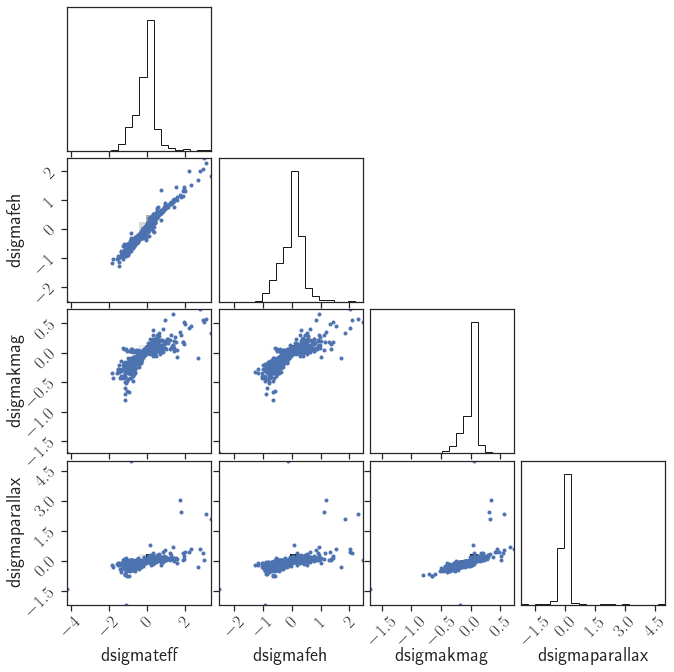

In [61]:
inputfile = "../input/isoinput_cks_valid.csv"
postdir = "../posterior_samples/posteriors_cks_linage2/"
_d = clean(inputfile, postdir)

In [111]:
print (len(pd.merge(_d, drot, on='kepid')), 'stars in Mazeh+15')
print (len(pd.merge(_d, drot[drot.acf], on='kepid')), 'stars in Mazeh+15 & rotation period')
print (len(pd.merge(_d[_d.idx], drot, on='kepid')), 'stars in Mazeh+15 & good isochrone fit & feh<0.4')
print (len(pd.merge(_d[_d.idx&(~_d.binflag)], drot, on='kepid')), 'stars in Mazeh+15 & good isochrone fit & feh<0.4 & no binary flag')

1054 stars in Mazeh+15
359 stars in Mazeh+15 & rotation period
1011 stars in Mazeh+15 & good isochrone fit & feh<0.4
948 stars in Mazeh+15 & good isochrone fit & feh<0.4 & no binary flag


(array([226., 221., 164., 122., 105.,  70.,  29.,  49.,  41.,  35.,  29.,
         21.,  16.,  13.,  16.,  10.,   7.,   5.,   2.,   2.,   1.,   2.,
          1.,   2.,   1.,   0.,   1.,   0.,   1.,   0.,   2.,   0.,   0.,
          1.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([0.0204291 , 0.1275903 , 0.2347515 , 0.3419127 , 0.4490739 ,
        0.55623511, 0.66339631, 0.77055751, 0.87771871, 0.98487991,
        1.09204111, 1.19920232, 1.30636352, 1.41352472, 1.52068592,
        1.62784712, 1.73500832, 1.84216952, 1.94933073, 2.05649193,
        2.16365313, 2.27081433, 2.37797553, 2.48513673, 2.59229794,
        2.69945914, 2.80662034, 2.91378154, 3.02094274, 3.12810394,
        3.23526514, 3.34242635, 3.44958755, 3.55674875, 3.66390995,
        3.77107115, 3.87823235, 3.98539356, 4.09255476, 4.19971596,
        4.30687716, 4.41403836, 4.52119956, 4.62836076, 4.73552197,
        4.84268317, 4.94984437, 5.05700557, 5.

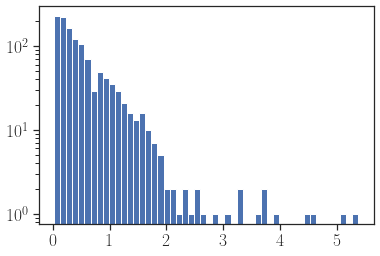

In [63]:
plt.yscale("log")
plt.hist(_d.dsigmaobs, bins=50);

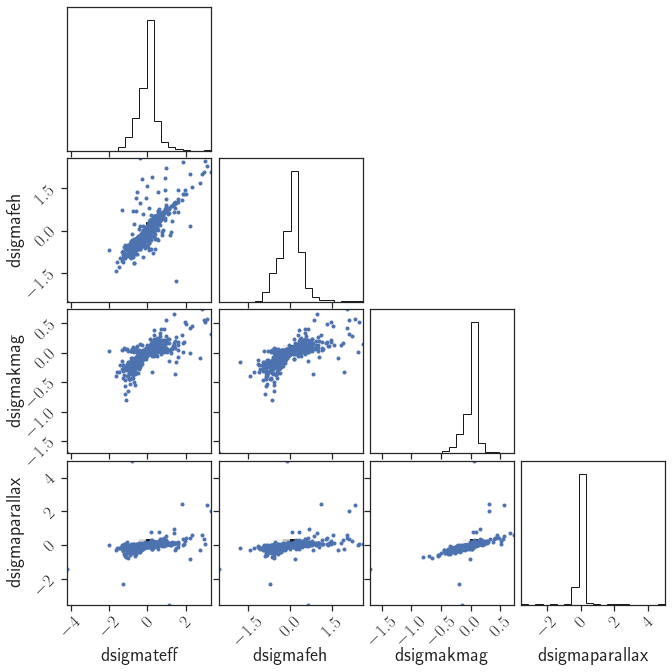

In [75]:
_dj = clean(inputfile, postdir, use_gyro=True)

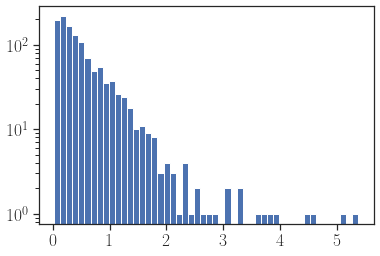

In [76]:
plt.yscale("log")
plt.hist(_dj.dsigmaobs, bins=50);

# 1149 well-behaved stars out of 1202.
# 1149 stars with median mass 0.00-inf Msun.
# 1077 apparently single stars with median mass 0.00-inf Msun.
# 948 stars in the final sample.


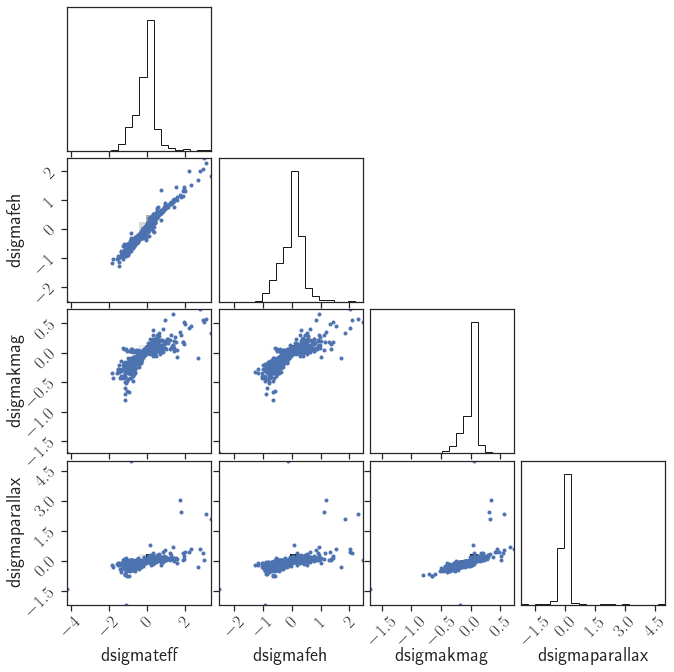

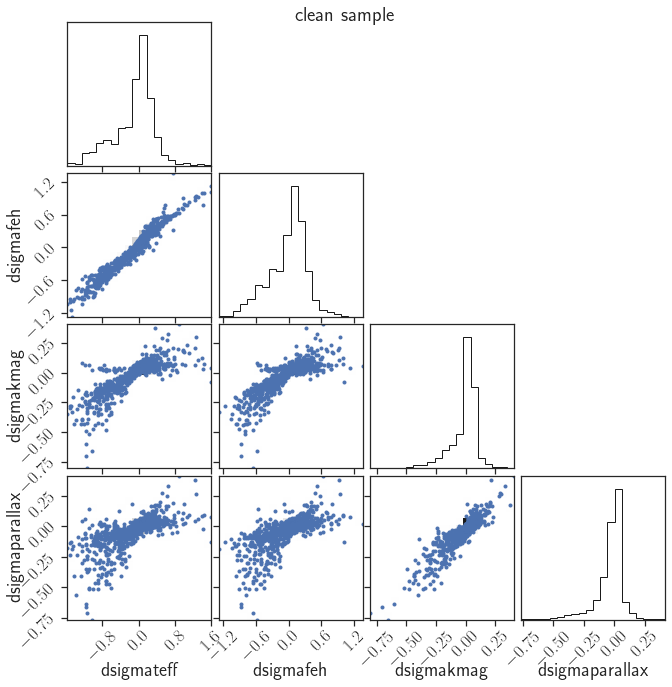

In [101]:
inputfile = "../input/isoinput_cks_valid.csv"
postdir = "../posterior_samples/posteriors_cks_linage2/"
d = define_sample(inputfile, postdir, drot, 0, np.inf)
samples = get_posterior_samples(d, postdir, agekey='age')

In [102]:
d.to_csv("iso_lina_all.csv", index=False)

# 1144 well-behaved stars out of 1202.
# 1144 stars with median mass 0.00-inf Msun.
# 1073 apparently single stars with median mass 0.00-inf Msun.


# 944 stars in the final sample.


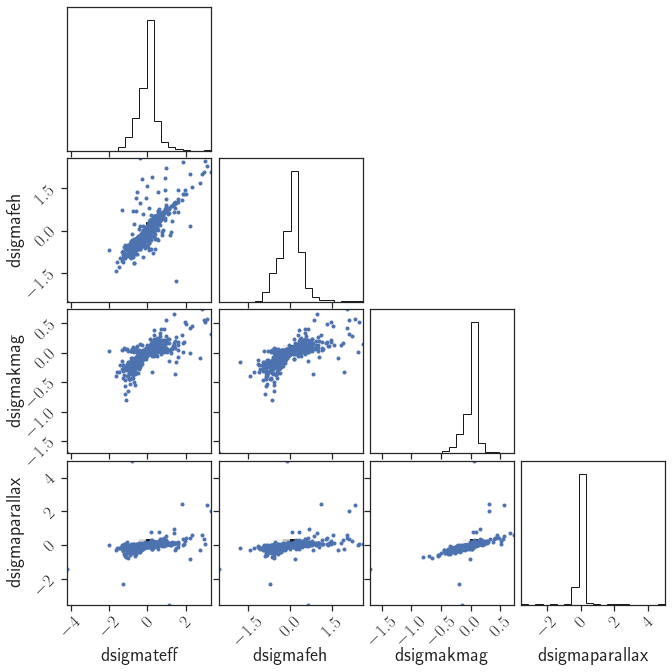

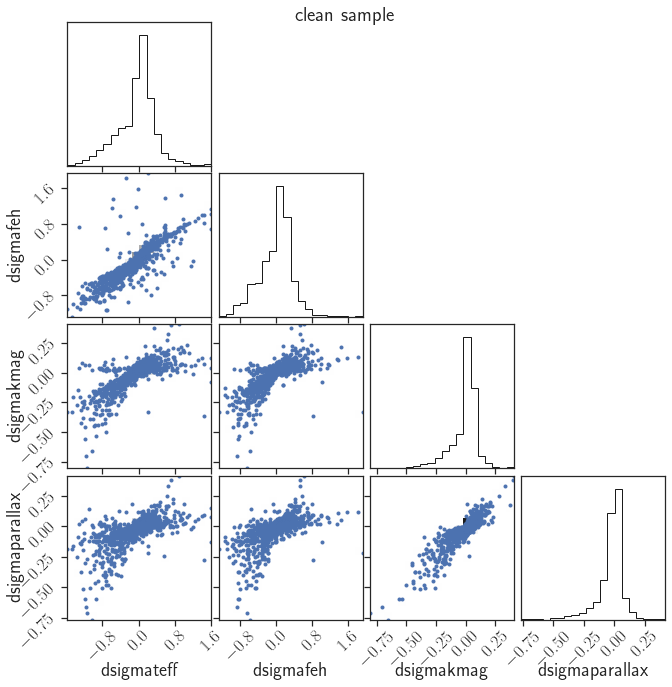

In [103]:
d = define_sample(inputfile, postdir, drot, 0, np.inf, use_gyro=True)
samples = get_posterior_samples(d, postdir, agekey='age', use_gyro=True)

In [104]:
d.to_csv("joint_lina_all.csv", index=False)

## main analysis

In [128]:
m_min, m_max = 0.75-0.05, 1.25+0.05

inputfile = "../input/isoinput_cks_valid.csv"
postdir = "../posterior_samples/posteriors_cks_logage/"
name = "iso_loga_m%.2f-%.2f"%(m_min, m_max)
agekey = "logage"
d = define_sample(inputfile, postdir, drot, m_min, m_max)
samples = get_posterior_samples(d, postdir, agekey='age')

# 1149 well-behaved stars out of 1202.
# 1031 stars with median mass 0.70-1.30 Msun.
# 964 apparently single stars with median mass 0.70-1.30 Msun.
# 855 stars in the final sample.


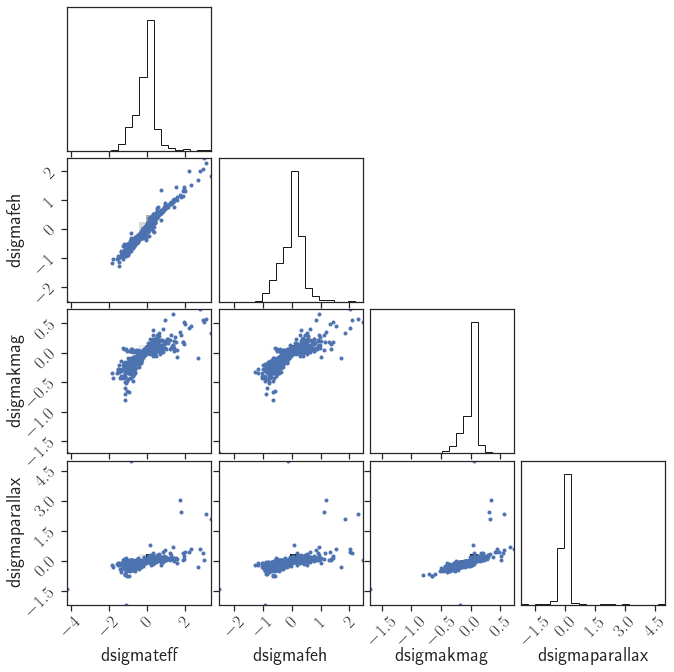

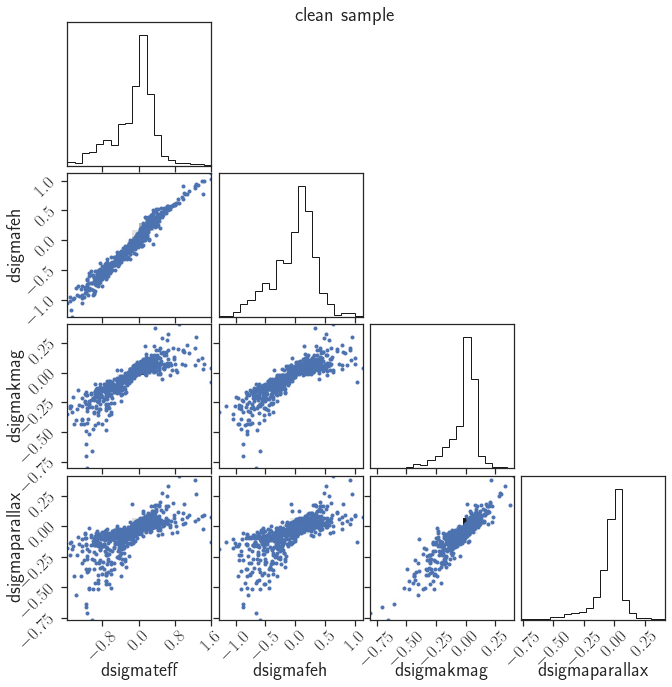

In [129]:
inputfile = "../input/isoinput_cks_valid.csv"
postdir = "../posterior_samples/posteriors_cks_linage2/"
name = "iso_lina_m%.2f-%.2f"%(m_min, m_max)
agekey = "linage"
d = define_sample(inputfile, postdir, drot, m_min, m_max)
samples = get_posterior_samples(d, postdir, agekey='age')

In [130]:
d.to_csv("%s.csv"%name, index=False)
np.savez("%s.npz"%name, samples=samples)

inputfile = "../input/isoinput_cks_valid.csv"
postdir = "../posterior_samples/posteriors_cks_logage/"
name = "joint_loga_m%.2f-%.2f"%(m_min, m_max)
agekey = "logage"
d = define_sample(inputfile, postdir, drot, m_min, m_max, use_gyro=True)
samples = get_posterior_samples(d, postdir, agekey='age', use_gyro=True)

# 1144 well-behaved stars out of 1202.
# 1029 stars with median mass 0.70-1.30 Msun.
# 964 apparently single stars with median mass 0.70-1.30 Msun.
# 855 stars in the final sample.


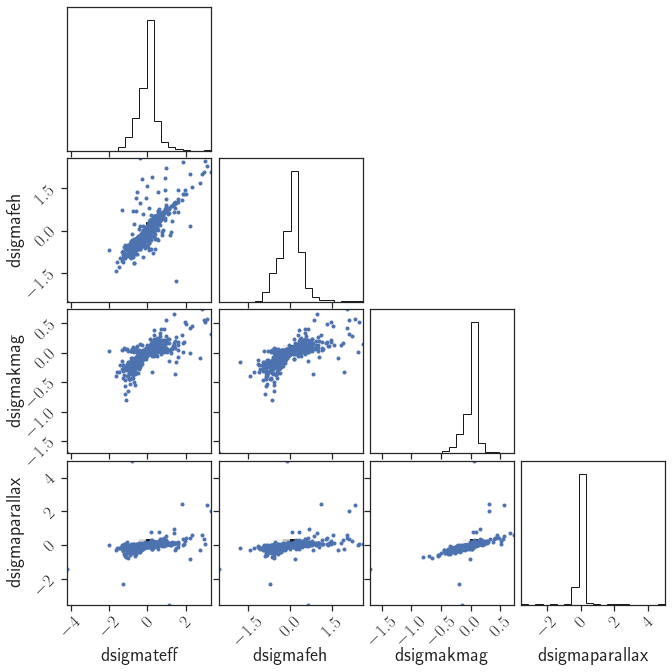

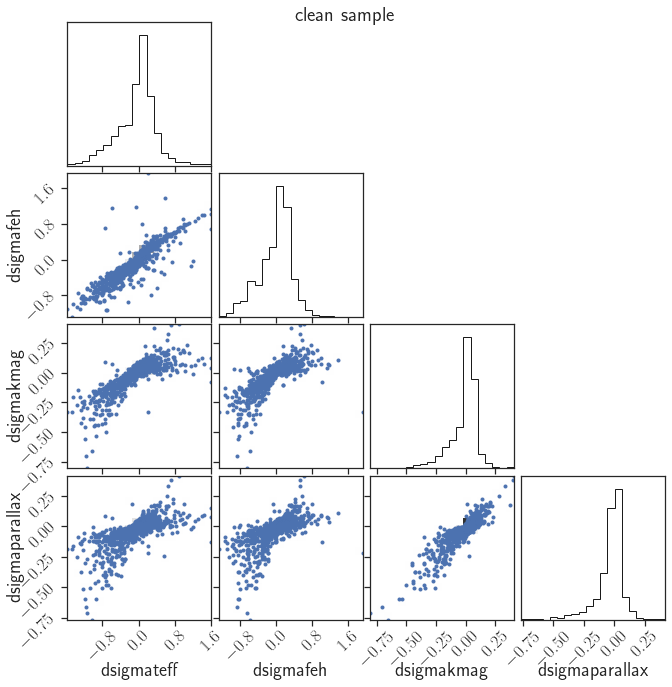

In [108]:
inputfile = "../input/isoinput_cks_valid.csv"
postdir = "../posterior_samples/posteriors_cks_linage2/"
name = "joint_lina_m%.2f-%.2f"%(m_min, m_max)
agekey = "linage"
d = define_sample(inputfile, postdir, drot, m_min, m_max, use_gyro=True)
samples = get_posterior_samples(d, postdir, agekey='age', use_gyro=True)

In [109]:
d.to_csv("%s.csv"%name, index=False)
np.savez("%s.npz"%name, samples=samples)